<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/advanced-llms/CourseWork/INFO_7374_Lecture_7_Basic_RAG_%2B_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Augmented Generation

## Why RAG?
Retrieval augmented generation (RAG) is an important technique for improving the performance and reliability of large language models (LLMs) by grounding their responses in external knowledge sources. RAG addresses a few key problems:

### Keeping LLMs Up-to-Date
LLMs are trained on vast amounts of data, but that training data can become stale over time. RAG allows LLMs to access the most current information when generating responses, without needing to retrain the model.

### Enhancing Accuracy on Specific Domains
While LLMs have broad general knowledge, they may struggle with domain-specific questions that require expert-level understanding. RAG can enhance LLM accuracy on niche topics by retrieving relevant information from specialized knowledge bases.

### Providing Verifiability and Citations
RAG systems typically cite the external sources used to generate a response. This allows users to verify the accuracy of the information and provides transparency into the model's decision making process.

### Mitigating "Hallucinations"
LLMs can sometimes generate false or nonsensical information, known as hallucinations. By grounding responses in authoritative external sources, RAG helps reduce these hallucinations and improves overall reliability.

![](https://blogs.nvidia.com/wp-content/uploads/2023/11/NVIDIA-RAG-diagram-scaled.jpg.webp)

## Basic RAG Algorithm Outline

### Retrieval Phase
1. The user provides an input query or prompt.
2. The RAG system uses the query to search an external knowledge base (e.g. a database, website, or document collection) and retrieves the most relevant snippets of information. This is typically done using semantic search technologies that can map the query to the relevant documents more accurately than keyword-based search.

### Generation Phase
3. The retrieved information snippets are concatenated with the original user query to form the input to a language model, usually a large pre-trained model like GPT-3.
4. The language model generates a response based on the query and the retrieved context, using its internal knowledge as well as the external information provided.
5. The generated response aims to directly answer the query by combining the language model's broad knowledge with the specific, up-to-date, and relevant information from the external sources.

## Basic RAG Implementation with `transformers`

In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch


In [ ]:
# Define the corpus of documents
corpus = [
    "Elephants are the largest land mammals on Earth and can weigh up to 6 tons.",
    "Cheetahs are the fastest land animals and can reach speeds of up to 70 mph.",
    "France is a country located in Western Europe, known for its art, cuisine, and fashion.",
    "The capital of France is Paris, which is also known as the City of Light.",
    "Australia is the world's sixth-largest country by total area and is home to unique wildlife like kangaroos and koalas.",
    "Brazil is the largest country in South America and is known for its vibrant culture, including the Carnival festival."
]

In [ ]:
# Initialize BERT tokenizer and model (document) -> vector/embedding/single list of floats
# Bert([1, T, C]) -> [1, T, C] -> Average over T's dim -> [1, 1, C] -> Goal: [1, C]
# [[1, 2], [3, 4], [5, 6]] -> [3 tokens, each token has 2 features]

# [[3, 4]] -> average over T's dim, [1, T, C] -> [1, C]

# [CLS]the brown fox[SEP]
# [CLS] token's representation

# [[1, 2], [3, 4], [5, 6]] -> [[1, 2]]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

The line `outputs.last_hidden_state[0, 0, :]` is extracting a specific part of the output from the BERT model.

#### BERT Model Output
- When you pass an input through the BERT model, it generates an output tensor called `last_hidden_state`.
- This tensor has the shape `(batch_size, sequence_length, hidden_size)`, where:
  - `batch_size` is the number of input sequences (in this case, it's 1 since we process one document at a time)
  - `sequence_length` is the length of the input sequence (padded or truncated to a fixed length)
  - `hidden_size` is the dimensionality of the hidden states in BERT (usually 768 for the base model)

#### Indexing the Output Tensor
- `outputs.last_hidden_state[0, 0, :]` is indexing into the `last_hidden_state` tensor:
  - The first index `0` selects the first (and only) sequence in the batch.
  - The second index `0` selects the hidden state corresponding to the first token in the sequence, which is typically the `[CLS]` token.
  - The `:` means we select all elements along the last dimension, i.e., the entire hidden state vector.

#### Significance of `[CLS]` Token
- In BERT, the `[CLS]` token is added to the beginning of every input sequence.
- The hidden state corresponding to the `[CLS]` token is often used as an aggregate representation of the entire input sequence.
- By selecting `outputs.last_hidden_state[0, 0, :]`, we are essentially extracting the `[CLS]` token's hidden state, which serves as an embedding for the entire document.


So in summary, `outputs.last_hidden_state[0, 0, :]` extracts the hidden state of the `[CLS]` token from the BERT model's output, which represents the entire input document, to be used for similarity calculations.

In [ ]:
# Encode the corpus documents
corpus_embeddings = []
for doc in corpus:
    inputs = tokenizer(doc, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        doc_embedding = outputs.last_hidden_state[0, 0, :].numpy()
    corpus_embeddings.append(doc_embedding)

In [ ]:
# Function to retrieve relevant documents based on query
def retrieve_docs(query, top_k=2):
    query_inputs = tokenizer(query, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        query_outputs = model(**query_inputs)
        query_embedding = query_outputs.last_hidden_state[0, 0, :].numpy()

    similarities = cosine_similarity([query_embedding], corpus_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    retrieved_docs = [corpus[i] for i in top_indices]
    retrieved_similarities = [similarities[i] for i in top_indices]

    return retrieved_docs, retrieved_similarities

In [ ]:
# Example usage
query = "What is the capital of France?"
relevant_docs, similarities = retrieve_docs(query)

In [ ]:
# Format the retrieved documents as context
context = "\n".join([f"Document {i+1}: {doc} (Similarity: {sim:.4f})" for i, (doc, sim) in enumerate(zip(relevant_docs, similarities))])
formatted_context = f"Query: {query}\n\nRelevant documents:\n{context}"

print(formatted_context)

Query: What is the capital of France?

Relevant documents:
Document 1: France is a country located in Western Europe, known for its art, cuisine, and fashion. (Similarity: 0.8476)
Document 2: The capital of France is Paris, which is also known as the City of Light. (Similarity: 0.8283)


## Basic RAG Implementation with `LlamaIndex`

In [ ]:
!pip install -q llama-index langchain sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00


In [ ]:
from llama_index.core.service_context import set_global_service_context
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.core import ServiceContext
from llama_index.legacy.embeddings.langchain import LangchainEmbedding

embed_model = LangchainEmbedding(
  HuggingFaceEmbeddings(model_name="google-bert/bert-base-uncased")
)
service_context = ServiceContext.from_defaults(llm=None, embed_model=embed_model)

set_global_service_context(service_context)

ModuleNotFoundError: No module named 'llama_index'

In [ ]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from transformers import BertTokenizer, BertModel
import torch
from pathlib import Path

# Define the corpus of documents
corpus = [
    "Elephants are the largest land mammals on Earth and can weigh up to 6 tons.",
    "Cheetahs are the fastest land animals and can reach speeds of up to 70 mph.",
    "France is a country located in Western Europe, known for its art, cuisine, and fashion.",
    "The capital of France is Paris, which is also known as the City of Light.",
    "Australia is the world's sixth-largest country by total area and is home to unique wildlife like kangaroos and koalas.",
    "Brazil is the largest country in South America and is known for its vibrant culture, including the Carnival festival."
]

# Save the corpus documents to a directory
corpus_dir = "corpus_docs"
Path(corpus_dir).mkdir(exist_ok=True)
for i, doc in enumerate(corpus):
    with open(f"{corpus_dir}/doc_{i}.txt", "w") as f:
        f.write(doc)

# Load documents from the directory
documents = SimpleDirectoryReader(corpus_dir).load_data()

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Create an index using the BERT model
index = VectorStoreIndex(documents, tokenizer=tokenizer, model=model)

# Function to retrieve relevant documents based on query
def retrieve_docs(query, top_k=2):
    query_engine = index.as_query_engine(similarity_top_k=top_k)
    retrieved_docs = query_engine.query(query)
    return retrieved_docs

# Example usage
query = "What is the capital of France?"
relevant_docs = retrieve_docs(query)

relevant_source_nodes = relevant_docs.source_nodes

# Format the retrieved documents as context
context = "\n".join([f"Document {i+1}: {doc.text} Score: {doc.score}" for i, doc in enumerate(relevant_source_nodes)])
formatted_context = f"Query: {query}\n\nRelevant documents:\n{context}"

print(formatted_context)


Query: What is the capital of France?

Relevant documents:
Document 1: The capital of France is Paris, which is also known as the City of Light. Score: 0.6060559045354293
Document 2: France is a country located in Western Europe, known for its art, cuisine, and fashion. Score: 0.5757815762461471


In [ ]:
!pip install -q faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 19.5 MB/s eta 0:00:00


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

corpus = [
    "Elephants are the largest land mammals on Earth and can weigh up to 6 tons.",
    "Cheetahs are the fastest land animals and can reach speeds of up to 70 mph.",
    "France is a country located in Western Europe, known for its art, cuisine, and fashion.",
    "The capital of France is Paris, which is also known as the City of Light.",
    "Australia is the world's sixth-largest country by total area and is home to unique wildlife like kangaroos and koalas.",
    "Brazil is the largest country in South America and is known for its vibrant culture, including the Carnival festival."
]

embed_model = HuggingFaceEmbeddings(model_name="google-bert/bert-base-uncased")
vectorstore = FAISS.from_texts(corpus, embedding=embed_model)

retriever = vectorstore.as_retriever(search_kwargs=dict(k=2))
query = "What is the capital of France?"
relevant_docs = retriever.invoke(query)
context = "\n".join([f"Document {i+1}: {doc.page_content}" for i, doc in enumerate(relevant_docs)])
formatted_context = f"Query: {query}\n\nRelevant documents:\n{context}"

print(formatted_context)


Query: What is the capital of France?

Relevant documents:
Document 1: The capital of France is Paris, which is also known as the City of Light.
Document 2: France is a country located in Western Europe, known for its art, cuisine, and fashion.


## Haystack

In [ ]:
!pip install -q haystack-ai  chroma-haystack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.1/265.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.0/506.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproj

In [ ]:
from haystack import Document

corpus = [
    "Elephants are the largest land mammals on Earth and can weigh up to 6 tons.",
    "Cheetahs are the fastest land animals and can reach speeds of up to 70 mph.",
    "France is a country located in Western Europe, known for its art, cuisine, and fashion.",
    "The capital of France is Paris, which is also known as the City of Light.",
    "Australia is the world's sixth-largest country by total area and is home to unique wildlife like kangaroos and koalas.",
    "Brazil is the largest country in South America and is known for its vibrant culture, including the Carnival festival."
]

docs = [Document(content=doc) for doc in corpus]

In [ ]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

doc_embedder = SentenceTransformersDocumentEmbedder(model="google-bert/bert-base-uncased")
doc_embedder.warm_up() # download model


In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6

Question can you use a different model for a text embedder here?

In [ ]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="google-bert/bert-base-uncased")


In [ ]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store, top_k=2)


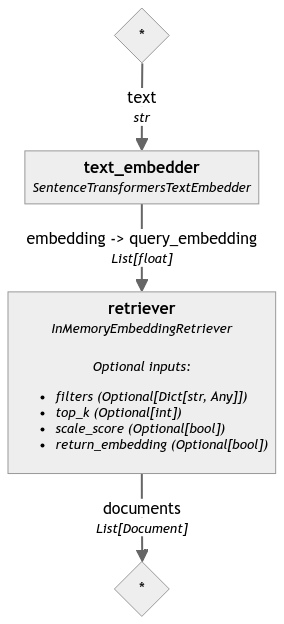

In [ ]:
from haystack import Pipeline
query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", text_embedder)
query_pipeline.add_component("retriever", retriever)
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

In [ ]:
query = "What is the capital of France?"

result = query_pipeline.run({"text": query})

context = "\n".join([f"Document {i+1}: {doc.content} Score: {doc.score}" for i, doc in enumerate(result['retriever']['documents'])])
formatted_context = f"Query: {query}\n\nRelevant documents:\n{context}"

print(formatted_context)



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query: What is the capital of France?

Relevant documents:
Document 1: The capital of France is Paris, which is also known as the City of Light. Score: 62.385650221333094
Document 2: France is a country located in Western Europe, known for its art, cuisine, and fashion. Score: 55.546081880260644


# Embeddings

<!-- ## Overview

### Problems With Using LMs in isolation
1. Interpretability: hard to determine how the LM came up with their answer
2. Outdated Information: LM soak up knowledge about the world by training on a lot of text. If we don't train on something, we cannot expect the LM to know about things it has never seen
3. Hallucinations: did the LM just make it up?
4. Controllability: LMs don't always "get" what you're asking of it

*Idea*: Fetch some data from your DB and include as part of the prompt

But it is not clear how to get the relevant information. Most times, the query will not be a nicely formatted SQL query. And the data collection you're fetching may not be well structured (pdfs, powerpoints, videos, text files) -->

Questions: how do you determine which pieces of data are the most relevant for answering a user's question?


![](https://partee.io/images/posts/vector-embeddings/embedding-creation.png)


### Intuition Behind Text Embeddings


Text embeddings are a way to represent words and sentences in a numerical form that can be understood and processed by machine learning models. The intuition behind text embeddings is to capture the semantic meaning of words and their relationships with each other in a high-dimensional space.

In this high-dimensional space, each dimension corresponds to a latent feature of the word, and the position of a word in this space is determined by its meaning and context in the language. Words that are semantically similar or share similar contexts in the language are positioned close to each other in this space, while words that are dissimilar are positioned far apart.

For example, in a well-trained text embedding model, words like "king" and "queen" would be closer to each other than words like "king" and "apple", because "king" and "queen" share more semantic and contextual similarities.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4Ut9ay0iZqvpWXkGuH39WNpjFn6Xr-IctFg&usqp=CAU)

![](https://miro.medium.com/v2/resize:fit:901/1*dT3594m7X1N0zdZhydw2FA.png)

![](https://i.ibb.co/YXHWYqx/Screenshot-2024-02-22-at-10-04-21-AM.png)

https://projector.tensorflow.org

![](https://cdn.openai.com/embeddings/draft-20220124e/vectors-mobile-1.svg)

### Difference Between Token Embeddings and Text Embeddings

Token Embeddings: These are representations of individual tokens (which could be words, subwords, or characters) in a text. Each token in the text is mapped to a vector in a high-dimensional space. The position of a token in this space is determined by its meaning and context in the language. Token embeddings are used to capture the semantic and syntactic relationships between individual tokens. For example, in a well-trained token embedding model, the token "king" would be closer to "queen" than to "apple" in the embedding space.

Text Embeddings: These are representations of entire pieces of text, such as sentences, paragraphs, or documents. A text embedding is a single vector that represents the entire piece of text. The position of a text in the embedding space is determined by the combined meaning and context of all the tokens in the text. Text embeddings are used to capture the overall semantic meaning of a piece of text. For example, in a well-trained text embedding model, the sentence "I love dogs" would be closer to "Dogs are my favorite" than to "I hate dogs" in the embedding space.

Token embeddings operate at the level of individual tokens and are used to capture the relationships between tokens, text embeddings operate at the level of entire pieces of text and are used to capture the overall semantic meaning of a piece of text.

### High Level Overview for Training Text Embedding Models

1. Model Training: The first step in training text embedding models involves training a model on a specific task. For instance, in the case of transformer-based models like GPT or BERT, the model is trained to predict the next token in a sequence given the previous tokens. This training process allows the model to learn the underlying patterns and structures in the text data.

2. Embedding Extraction: Once the model is trained, we can extract the embeddings from the model. These embeddings may not final output of the model, but rather the intermediate representations that the model learns during training. Specifically, the embeddings are the output of one of the model's intermediate layers.

### Extracting Embeddings from GPT

In transformer-based models like GPT, the training process involves predicting the next token in a sequence. However, the embeddings for each token are not the final output of the model. Instead, they are intermediate representations that the model learns during training.

When the model is given a sequence of tokens, it first converts each token into an initial embedding vector. These initial embeddings are then processed by the transformer layers, which use self-attention mechanisms to create new embeddings that capture the context of each token in relation to all other tokens in the sequence.

The final embeddings for each token are the output of the last transformer layer. These embeddings are then passed through a linear layer and a softmax function to produce a probability distribution over the vocabulary for the next token prediction.

To get the embeddings for a piece of text, you can simply take the output of the last transformer layer before it is passed through the final linear layer and softmax function. These embeddings will be a sequence of vectors, with one vector for each token in the input text.

For example, in GPT models, if you want to get the embedding for a sentence, you can take the output of the last transformer layer for the last token in the sentence. This will give you a single vector that represents the entire sentence. Similarly, if you want to get the embeddings for each token in the sentence, you can take the output of the last transformer layer for each token.

![](https://vaclavkosar.com/images/transformer-architecture-tokens-vs-embeddings.drawio.svg)

#### GPT Embedding Code Example - Last Token

In [ ]:
# last token
from transformers import GPT2Model, GPT2Tokenizer

# Initialize the tokenizer and the model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Encode the text
input_text = "This is a sample sentence for embedding."
encoded_input = tokenizer(input_text, return_tensors='pt')

# Print the shape of the encoded input
print(f"Shape of encoded input: {encoded_input['input_ids'].shape}")

# Get the embeddings
outputs = model(**encoded_input)

# The output of the GPT-2 model is a tuple where the first element represents
# the hidden states from all layers. We take the hidden states from the last layer.
last_layer_hidden_states = outputs.last_hidden_state

# Print the shape of the last layer hidden states
print(f"Shape of last layer hidden states: {last_layer_hidden_states.shape}")

print("Extracting last token's embedding...")
# To get a single vector for the entire sentence, we take the embedding of the last token
sentence_embedding = last_layer_hidden_states[0, -1, :]

print(f"Embedding shape: {sentence_embedding.shape}")


Shape of encoded input: torch.Size([1, 9])
Shape of last layer hidden states: torch.Size([1, 9, 768])
Extracting last token's embedding...
Embedding shape: torch.Size([768])


#### GPT Embedding Code Example - Average over All Tokens

In [ ]:
# average
from transformers import GPT2Model, GPT2Tokenizer

# Initialize the tokenizer and the model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Encode the text
input_text = "This is a sample sentence for embedding."
encoded_input = tokenizer(input_text, return_tensors='pt')

# Print the shape of the encoded input
print(f"Shape of encoded input: {encoded_input['input_ids'].shape}")

# Get the embeddings
outputs = model(**encoded_input)

# The output of the GPT-2 model is a tuple where the first element represents
# the hidden states from all layers. We take the hidden states from the last layer.
last_layer_hidden_states = outputs.last_hidden_state

# Print the shape of the last layer hidden states
print(f"Shape of last layer hidden states: {last_layer_hidden_states.shape}")

print("Average all tokens' embedding...")
# To get a single vector for the entire sentence, we take the mean of all token vectors
sentence_embedding = last_layer_hidden_states.mean(dim=1)[0]

print(f"Embedding shape: {sentence_embedding.shape}")


Shape of encoded input: torch.Size([1, 9])
Shape of last layer hidden states: torch.Size([1, 9, 768])
Average all tokens' embedding...
Embedding shape: torch.Size([768])


### Extracting Text Embeddings From BERT

One common strategy is to take the hidden state of the special [CLS] token at the beginning of the sentence. This token is designed to capture the overall semantics of the sentence. Another strategy is to average the hidden states of all the tokens in the sentence.

#### BERT Embedding Code Example - [CLS]

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

# Initialize the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Input text
input_text = "This is a sample sentence for embedding."

# Add [CLS] and [SEP] tokens and tokenize
tokenized_input = tokenizer.tokenize(input_text)
tokenized_input = ['[CLS]'] + tokenized_input + ['[SEP]']

print(f"Tokenized input with [CLS] and [SEP]: {tokenized_input}")

# Convert tokens to their IDs
input_ids = tokenizer.convert_tokens_to_ids(tokenized_input)

# Convert list of input IDs into tensor
input_ids_tensor = torch.tensor([input_ids])

# Get the embeddings
outputs = model(input_ids_tensor)

# The output of the BERT model is a tuple where the first element represents
# the hidden states from all layers. We take the hidden states from the last layer.
last_layer_hidden_states = outputs.last_hidden_state

print(f"Shape of last layer hidden states: {last_layer_hidden_states.shape}")

# To get a single vector for the entire sentence, we take the embedding of the [CLS] token
cls_embedding = last_layer_hidden_states[0, 0, :]

print(f"CLS embedding: {cls_embedding.shape}")


Tokenized input with [CLS] and [SEP]: ['[CLS]', 'this', 'is', 'a', 'sample', 'sentence', 'for', 'em', '##bed', '##ding', '.', '[SEP]']
Shape of last layer hidden states: torch.Size([1, 12, 768])
CLS embedding: torch.Size([768])


#### BERT Embedding Code Example - Average over All Tokens

In [ ]:
from transformers import BertModel, BertTokenizer

# Initialize the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Encode the text
input_text = "This is a sample sentence for embedding."
encoded_input = tokenizer(input_text, return_tensors='pt')

print(f"Encoded input: {encoded_input}")

# Get the embeddings
outputs = model(**encoded_input)

# The output of the BERT model is a tuple where the first element represents
# the hidden states from all layers. We take the hidden states from the last layer.
last_layer_hidden_states = outputs.last_hidden_state

print(f"Shape of last layer hidden states: {last_layer_hidden_states.shape}")

# To get a single vector for the entire sentence, we take the mean of all token vectors
sentence_embedding = last_layer_hidden_states.mean(dim=1)

print(f"Sentence embedding (average of all token vectors): {sentence_embedding.shape}")


Encoded input: {'input_ids': tensor([[ 101, 2023, 2003, 1037, 7099, 6251, 2005, 7861, 8270, 4667, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Shape of last layer hidden states: torch.Size([1, 12, 768])
Sentence embedding (average of all token vectors): torch.Size([1, 768])


Classify positive/negative sentiment

Sentence: im really happy
sentiment: positive

Sentence: im really sad
sentiment: negative

example 1 input
example 1 output
example 1 good/bad

example 2 input: input
example 2 output: input + output
example 2 bad

input
ouput
good/bad: LLM




## Evaluation

Linear probe classification: the embeddings are used as features to train a linear classifier to solve a variety of downstream tasks


Massive Text Embedding Benchmark (MTEB)

![](https://huggingface.co/blog/assets/110_mteb/mteb_diagram_white_background.png)



- **Bitext Mining**:
  - Inputs: Two sets of sentences from different languages.
  - Task: Find the best match for each sentence in the first set from the second set, typically translations.
  - Model: Embed sentences and find closest pairs using cosine similarity.
  - Metrics: F1 (main), accuracy, precision, and recall.

- **Classification**:
  - Inputs: Train and test sets.
  - Task: Train a logistic regression classifier with embedded train set and score on the test set.
  - Model: Logistic regression with 100 maximum iterations.
  - Metrics: Accuracy (main), average precision, and F1.

- **Clustering**:
  - Inputs: A set of sentences or paragraphs.
  - Task: Group texts into meaningful clusters.
  - Model: Mini-batch k-means with batch size 32 and k equal to the number of different labels.
  - Metrics: V-measure (main).

- **Pair Classification**:
  - Inputs: A pair of text inputs.
  - Task: Assign a binary label (e.g., duplicate or paraphrase pairs).
  - Model: Embed texts and compute distance using various metrics.
  - Metrics: Best binary threshold accuracy, average precision, F1, precision, and recall. Average precision based on cosine similarity (main).

- **Reranking**:
  - Inputs: A query and a list of relevant and irrelevant reference texts.
  - Task: Rank the references according to their relevance to the query.
  - Model: Embed references and compare to query using cosine similarity.
  - Metrics: Mean MRR@k and MAP (main).

- **Retrieval**:
  - Inputs: A corpus, queries, and a mapping to relevant documents.
  - Task: Find relevant documents for each query.
  - Model: Embed queries and corpus documents, compute similarity scores using cosine similarity.
  - Metrics: nDCG@k, MRR@k, MAP@k, precision@k, recall@k. nDCG@10 (main).

- **Semantic Textual Similarity (STS)**:
  - Inputs: A pair of sentences.
  - Task: Determine their similarity with continuous scores.
  - Model: Embed sentences and compute similarity using various distance metrics.
  - Metrics: Pearson and Spearman correlations. Spearman correlation based on cosine similarity (main).

- **Summarization**:
  - Inputs: Human-written and machine-generated summaries.
  - Task: Score the machine summaries.
  - Model: Embed summaries, compute distances to human summaries, and keep the closest score.
  - Metrics: Pearson and Spearman correlations with ground truth assessments. Spearman correlation based on cosine similarity (main).


## Algorithms

Many text embedding algorithms have been developed in parallel to GPT-like models and the training process is different.


Terminology:

- in-batch negatives: For each example in a mini batch of $M$ examples ,the other $M-1$ in the batch are used as negative examples.



### SentenceBert

https://arxiv.org/abs/1908.10084

Task: Efficiently compute the similarity between two sentences

With vanilla BERT

$$\text{similarity} = \text{linear}(BERT(\text{sentence 1} + \text{sentence2})[0])$$

Cons: Requires both sentences to be fed into the network, scales quadratically, slow


Sentence-BERT (SBERT) is a modification of the pre-trained BERT model to generate sentence embeddings more efficiently. Unlike BERT, which generates embeddings for individual tokens in a sentence, SBERT generates embeddings for entire sentences.

![](https://roomylee.github.io/assets/images/blog/2020-02-20-sentence-bert/figure1-and-2.png)

In SBERT, the embeddings are generated by passing sentences through the model and then applying a pooling operation (like mean or max pooling) to the output of the model. This results in a single vector that represents the entire sentence. The advantage of this approach is that it allows for the pre-computation of sentence embeddings, which can then be compared using simple distance metrics like cosine similarity. This makes SBERT much more efficient than BERT for tasks that involve comparing the semantic similarity of sentences.

#### Training Objectives


Let $u$ and $v$ be the sentence embeddings, and $|u-v|$ is the element wise difference.

##### Classification Loss (figure 1)

$u$, $v$, $|u-v|$ are concatenated then passed through a linear layer

$$L = \text{cross entropy}(\text{softmax}(W_t(u,v,|u-v|)))$$

##### Cosine Similarity Loss (figure 2)

$$L = MSE(\text{cos_sim(u, v)}, \text{gt_sim})$$




#### Data
https://huggingface.co/datasets/snli

The SNLI corpus (version 1.0) is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI), also known as recognizing textual entailment (RTE).

![](https://i.ibb.co/LRPZbmF/Screenshot-2024-02-22-at-10-59-47-AM.png)

#### Usage Example

https://www.sbert.net/index.html

In [ ]:
!pip install -q sentence_transformers datasets

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Our sentences to encode
sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of string.",
    "The quick brown fox jumps over the lazy dog."
]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding.shape)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: (384,)

Sentence: Sentences are passed as a list of string.
Embedding: (384,)

Sentence: The quick brown fox jumps over the lazy dog.
Embedding: (384,)



#### Finetuning Example

In [ ]:
from sentence_transformers import (
    SentenceTransformer,
    SentencesDataset,
    InputExample,
    losses
)
from torch.utils.data import DataLoader

model = SentenceTransformer("nli-distilroberta-base-v2")
train_examples = [
    InputExample(texts=["My first sentence", "My second sentence"], label=0.8),
    InputExample(texts=["Another pair", "Unrelated sentence"], label=0.3),
]

# Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

### Contrastive Learning Background

![](https://production-media.paperswithcode.com/tasks/34886962-1da9-4e2d-a833-40699515230a.png)

Contrastive learning is a type of machine learning method where the focus is on learning to distinguish between different types of data. The technique involves using an anchor sample, positive samples (similar to the anchor), and negative samples (dissimilar to the anchor). The objective is to bring the anchor and positive samples closer together in the representation space, while pushing the anchor and negative samples further apart.

This approach is valuable because it allows models to extract meaningful representations from unlabeled or partially labeled data. It's been successfully applied in various fields like computer vision, natural language processing, and reinforcement learning.






#### InfoNCE

https://arxiv.org/pdf/1807.03748.pdf

The InfoNCE loss, where NCE stands for Noise-Contrastive Estimation, is a contrastive loss function used for self-supervised learning. The InfoNCE loss is designed to bring representations of positive pairs closer together in the embedding space while pushing representations of negative pairs further apart.

$$
\min L_{\text{cont}} = -\frac{1}{n} \sum_{i} \log \left( \frac{e^{s_\theta(q_i, p_i^+)}}{e^{s_\theta(q_i, p_i^+)} + \sum_{j} e^{s_\theta(q_i, {p}_j^-)}} \right)
$$

$$s_\theta(p, q) = cos(E_q, E_p)\ / \ \tau$$


$q_i$​: A query, which is typically a representation of a data sample, often generated by a neural network.

$p_i$​: A positive example that is semantically related to the query $q_i$. In many cases, this could be a different augmented version of the same data point as the query.

$p_j^-$​: Negative examples that are not semantically related to the query $q_i$.
$s_\theta$: A scoring function, which measures the similarity between two representations. A common choice for this function is the dot product, but it can also be a more complex function like a neural network.
$n$: The number of query-positive pairs; in practice, it often corresponds to the batch size.

In [ ]:
import torch

def infonce_loss(query, positive, negatives, temperature=0.1):
    """
    InfoNCE loss implementation

    Args:
        query (torch.Tensor): Query feature from the model, shape (feature_dim,).
        positive (torch.Tensor): Positive feature from the model, shape (feature_dim,).
        negatives (torch.Tensor): Negative features from the model, shape (num_negatives, feature_dim).
        temperature (float): Temperature scaling parameter.

    Returns:
        torch.Tensor: The InfoNCE loss.
    """
    # Step 1: Compute the dot product (similarity) between the query and the positive sample
    positive_similarity = torch.dot(query, positive) / temperature

    # Step 2: Compute the dot product (similarity) between the query and each negative sample
    negative_similarities = torch.matmul(negatives, query) / temperature

    # Step 3: Concatenate the positive similarity with the negative similarities
    all_similarities = torch.cat([positive_similarity.unsqueeze(0), negative_similarities], dim=0)

    # Step 4: Divide the exponentiated positive similarity by the sum of exponentiated similarities
    exponentiated_similarities = torch.exp(all_similarities)
    probability = torch.exp(positive_similarity) / torch.sum(exponentiated_similarities)

    # Step 5: Compute the negative logarithm of the probability
    loss = -torch.log(probability)

    return loss


### Data

How do you construct positive pairs? There are many works that explore this question.


### OpenAI

https://arxiv.org/abs/2201.10005

Neighboring pieces of text on the internet are positive samples


### E5

https://arxiv.org/pdf/2212.03533.pdf

Introduces the CCPairs dataset

- (post, comment) pairs from Reddit
- (question, upvoted answer) pairs from Stack exchange
- (entity name + section title, passage) from Wikipedia
- (title, abstract) from scientific papers
- (title, passage) from Common Crawl web pages + news sources

Filtering
- remove reddit comments that are too long (>4096 character)
- remove reddit comments that have scores < 1
- remove passages from web pages with high perplexity


InfoNCE loss



### E5 Mistral Instruct

https://arxiv.org/pdf/2401.00368.pdf

- Uses Mistral to generate synthetic data

- Finetunes Mistral on this synthetic dataset using the InfoNCE loss

![](https://i.ibb.co/1LY2q9w/Screenshot-2024-02-22-at-7-46-56-PM.png)


### SimCSE
https://arxiv.org/abs/2104.08821


For computer vision representation learning, an effective solution is to take two random transformations of the *same* image (eg cropping, flipping, distortion, and rotation).

A similar approach has been recently adopted in learning text representations by applying augmentation techniques such as word deletion, reordering, and substitution but is difficult because of the discrete nature.

![](https://i.ibb.co/G9Tbs5K/Screenshot-2024-02-22-at-6-05-45-PM.png)

SimCSE constructs positive samples by passing a sentence through the network multiple times (using different dropout masks). Negative samples are randomly sampled from the batch.


Trained using the InfoNCE loss.


### Matryoshka Representation Learning

https://arxiv.org/pdf/2205.13147.pdf

- encodes information at coarse to fine granularities in a single vector
- different tasks have different compute requirements. So it may be infeasible to use a single embedding vector for all tasks
- MRL solves this with a “Russian-doll” like training step. Create O(log n) subsets (dolls) of increasing size, and apply the training loss for all subsets and add them up. This forces all increasing subsets to be meaningful.

![](https://i.ibb.co/mbNqL01/Screenshot-2024-02-22-at-12-46-44-PM.png)



## Applications
- Information Retrieval: Enhancing search engines by finding relevant documents based on the similarity of their embeddings to a query embedding.
- Recommendation Systems: Recommending similar items (e.g., articles, products) based on the similarity of their text descriptions' embeddings.
- Text Classification: Assigning categories or labels to text, such as spam detection or topic classification, by using embeddings as features for machine learning models.
- Sentiment Analysis: Determining the sentiment of text (positive, negative, neutral) by analyzing the embeddings of words or sentences.

# Retrieval

## Evaluation

https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

### Metric: MRR (Mean Reciprocal Rank)

MRR (Mean Reciprocal Rank) is a metric used to evaluate the effectiveness of a ranking system. It is commonly used in information retrieval and natural language processing tasks such as search engine ranking or question answering.

MRR is calculated as the average of the reciprocal ranks of the first relevant item in a list of ranked items. The rank of the first relevant item is the position of the first relevant item in the list, with the top position being rank 1. If there are no relevant items in the list, the reciprocal rank is 0.

The formula for MRR is:

$$\text{MRR} = \frac{1}{Q} \sum_{i=1}^{Q} \frac{1}{\text{rank}_i}$$

where $Q$ is the number of queries, and $\text{rank}_i$ is the rank of the first relevant item for the $i$-th query.

Higher is better

In [ ]:
def mean_reciprocal_rank(ranks):
    """Calculate Mean Reciprocal Rank (MRR).

    Args:
        ranks (list of int): List of ranks of the first relevant item for each query.

    Returns:
        float: Mean Reciprocal Rank (MRR).
    """
    return sum(1.0 / rank for rank in ranks if rank > 0) / len(ranks)

# Example usage
query_ranks = [1, 3, 2, 0, 4]  # 0 indicates no relevant item found
mrr = mean_reciprocal_rank(query_ranks)
print(f"MRR: {mrr}")


MRR: 0.41666666666666663


### NDCG

Normalized Discounted Cumulative Gain (NDCG) is a metric used to evaluate the quality of a ranking model. More relevant items should be ranked higher than less relevant ones. Therefore, a higher NDCG score indicates that the relevant items are ranked higher.

#### How to Calculate NDCG?

1. **Discounted Cumulative Gain (DCG):** DCG weighs each relevance score based on its position in the ranking. The recommendations at the top get a higher weight, while the relevance of those at the bottom get a lower weight. The formula for DCG is:

    ```
    DCG = relevance_score_1 + relevance_score_2/log(2) + relevance_score_3/log(3) + ... + relevance_score_n/log(n)
    ```

    Here, `relevance_score_i` is the relevance score of the item at position `i` in the ranking, and `log(i)` is the logarithm of `i`.

2. **Ideal Discounted Cumulative Gain (IDCG):** IDCG is the DCG score when we recommend the most relevant items first. In other words, it's the DCG of the ideal ranking.

Finally, NDCG is calculated by dividing the DCG by the IDCG. This normalization allows for fair comparisons between different lists, regardless of their lengths.

Here's a concrete example:

Suppose we have a list of five items with true relevance scores `[3, 2, 1, 0, 0]` and our model gives them relevance scores `[3, 2, 0, 0, 1]`. We can calculate DCG and IDCG as follows:

```
DCG = 3 + 2/log(2) + 0/log(3) + 0/log(4) + 1/log(5) = 4.67
IDCG = 3 + 2/log(2) + 1/log(3) + 0/log(4) + 0/log(5) = 4.76
```

Then, we calculate NDCG:

```
NDCG = DCG / IDCG = 4.67 / 4.76 = 0.98
```

#### Is Higher NDCG Better or Worse?

A higher NDCG score is better. The NDCG score ranges from 0 to 1. A score of 1 means that the order of items in a ranking is perfectly ordered by relevance, while a score of 0 is the opposite. Therefore, the closer the NDCG score is to 1, the better the ranking model is at ordering items by their relevance.

### Dataset: MS MARCO (nDCG)

The MS MARCO (Microsoft MAchine Reading COmprehension) benchmark is a large-scale dataset and set of evaluation metrics designed for research in information retrieval, natural language processing, and machine learning. It was created to improve search and question-answering systems by providing real-world queries and relevant documents. The dataset includes:

1. Passage Ranking: A collection of passages and queries where the goal is to rank the passages in order of relevance to the query.
2. Document Ranking: Similar to passage ranking, but with entire documents instead of passages.
3. Question Answering: A set of questions with corresponding passages that contain the answers.

The benchmark is used to evaluate models on tasks such as passage retrieval, document retrieval, and question answering, with the aim of improving the accuracy and relevance of search results and answers provided by AI systems.


## Baseline: BM25

BM25 is a ranking function used in information retrieval systems to rank documents based on their relevance to a given search query. It is based on the probabilistic retrieval model and incorporates the following key ideas:

1. **Term Frequency (TF)**: The more often a query term appears in a document, the more relevant that document is likely to be to the query.
2. **Inverse Document Frequency (IDF)**: Terms that appear in many documents are less informative and are given less weight.
3. **Document Length Normalization**: Longer documents are more likely to contain a term by chance, so the scoring function is normalized to prevent bias towards longer documents.

Inverse Document Frequency (IDF) is a measure used in information retrieval and text mining to reflect the importance of a term in a collection of documents. It is based on the idea that terms that appear frequently across many documents are less informative than those that appear less frequently. The IDF of a term is calculated as follows:

$$
\text{IDF}(t) = \log \left( \frac{N}{n_t} \right)
$$

where:
- $N$ is the total number of documents in the collection.
- $n_t$ is the number of documents containing the term $t$.
- $\log$ is the logarithm, typically using base 10 or base $e$ (natural logarithm).

The logarithm is used to dampen the effect of the term frequency. As a result, terms that are present in many documents (such as common words like "the" or "and") will have a lower IDF and contribute less to the overall weight of the term in the document. Conversely, terms that are rare across the document collection will have a higher IDF and contribute more to the term's weight.



The BM25 formula for a document \(d\) and a query \(q\) is:

$$
\text{score}(d, q) = \sum_{i=1}^{n} \text{IDF}(q_i) \cdot \frac{\text{TF}(q_i, d) \cdot (k_1 + 1)}{\text{TF}(q_i, d) + k_1 \cdot (1 - b + b \cdot \frac{\text{length}(d)}{\text{avg_length}})}
$$

where:

- $q_i$ is the \(i\)-th term in the query.
- $\text{TF}(q_i, d)$ is the term frequency of \(q_i\) in document \(d\).
- $\text{IDF}(q_i)$ is the inverse document frequency of \(q_i\).
- $k_1$ and $b$ are free parameters, usually chosen empirically.
- $\text{length}(d)$ is the length of document \(d\).
- $\text{avg_length}$ is the average document length in the collection.

In essence, BM25 scores each document based on the occurrence of query terms, giving higher scores to documents that contain many query terms and penalizing longer documents.


## ColBERT

Efficient and Effective Passage Search via Contextualized Late Interaction over BERT

https://arxiv.org/pdf/2004.12832.pdf

Task: document ranking

Problem: Existing ranking models are expensive since they pass every query-document pair through a model to create a relevance score

$$\text{score} = \text{net}(\text{query}, \text{document})$$

The amount of compute scales *quadratically* with the number of queries and documents.

ColBERT:
* encodes query and document individually, then uses a cheap way to measure their fine-grained similarity -- this is called late-interaction
* number of model calls scales *linearly* with the number of queries and documents




![](https://i.ibb.co/C7RFhZ8/Screenshot-2024-02-25-at-5-11-25-PM.png)

* (a) Representation based similarity: independently compute and embedding for $q$ and $d$ and estimate relevance as a single similarity score between two vectors

* (b) and (c): Interaction based methods: Instead of summarizing $q$ and $d$ into individual embeddings, these rankers model word and phrase level relationships across $q$ and $d$ and match them using a deep neural network. Good performance, but requires more compute. Empirically, Fine grained matching is useful.
    * (b): feed the neural network and interaction matrix that reflects the similarity between every pair of words across $q$ and $d$
    * (c): more powerful interaction-based which model the interaction between word within as across $q$ and $d$ at the same time
* (d) Late interaction models, uses pre computation and delays the query-document interaction.

In ColBERT, every query embedding interacts with all document embeddings via a MaxSim operator, which computes maximum similairty (eg cosine similarity), and the scalar outputs of these operators are summed across query terms.


## Ragatouille

In [ ]:
!pip install -q ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 28.6 M

In [ ]:
!pip uninstall --y faiss-cpu & pip install faiss-gpu

Found existing installation: faiss-cpu 1.8.0
Uninstalling faiss-cpu-1.8.0:
  Successfully uninstalled faiss-cpu-1.8.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.3 MB/s eta 0:00:00


In [ ]:
from ragatouille import RAGPretrainedModel
from ragatouille.utils import get_wikipedia_page

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
corpus = [
    "Elephants are the largest land mammals on Earth and can weigh up to 6 tons.",
    "Cheetahs are the fastest land animals and can reach speeds of up to 70 mph.",
    "The shortest war in history was between Zanzibar and England in 1896. Zanzibar surrendered after 38 minutes.",
    "The world's oldest known musical instrument is a flute made from a bird bone, discovered in Germany and dated to be about 40,000 years old.",
    "The word 'hippopotomonstrosesquippedaliophobia' ironically means a fear of long words.",
    "The average human body contains enough carbon to make 900 pencils.",
    "The world's most expensive coffee, Kopi Luwak, is made from coffee beans eaten and excreted by the Asian palm civet.",
    "The shortest commercial flight in the world is between the islands of Westray and Papa Westray in Scotland, lasting only 1.5 minutes.",
    "The world's quietest room, called the anechoic chamber, is located at Microsoft's headquarters in Washington State.",
    "The probability of a coin landing on its edge is about 1 in 6,000 tosses.",
    "The world's oldest known musical composition is the Hurrian Hymn No. 6, which dates back to around 1400 BC.",
    "The world's most expensive pizza, the Louis XIII, costs $12,000 and takes 72 hours to make.",
    "France is a country located in Western Europe, known for its art, cuisine, and fashion.",
    "The capital of France is Paris, which is also known as the City of Light.",
    "Australia is the world's sixth-largest country by total area and is home to unique wildlife like kangaroos and koalas.",
    "Brazil is the largest country in South America and is known for its vibrant culture, including the Carnival festival."
]
index_path = RAG.index(index_name="my_index", collection=corpus)



[Mar 17, 23:11:32] #> Creating directory .ragatouille/colbert/indexes/my_index 


[Mar 17, 23:11:34] [0] 		 #> Encoding 16 passages..
[Mar 17, 23:11:38] [0] 		 avg_doclen_est = 22.75 	 len(local_sample) = 16
[Mar 17, 23:11:38] [0] 		 Creating 256 partitions.
[Mar 17, 23:11:38] [0] 		 *Estimated* 364 embeddings.
[Mar 17, 23:11:38] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/my_index/plan.json ..
[Mar 17, 23:11:40] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Mar 17, 23:13:12] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[0.043, 0.035, 0.045, 0.04, 0.036, 0.044, 0.033, 0.037, 0.047, 0.043, 0.055, 0.033, 0.046, 0.032, 0.039, 0.048, 0.051, 0.034, 0.03, 0.052, 0.047, 0.044, 0.044, 0.056, 0.04, 0.044, 0.037, 0.044, 0.037, 0.051, 0.051, 0.03, 0.052, 0.04, 0.04, 0.042, 0.032, 0.045, 0.036, 0.043, 0.033, 0.038, 0.039, 0.041, 0.031, 0.038, 0.035, 0.048, 0.04

0it [00:00, ?it/s]

[Mar 17, 23:14:42] [0] 		 #> Encoding 16 passages..


1it [00:00,  9.25it/s]
100%|██████████| 1/1 [00:00<00:00, 1665.73it/s]

[Mar 17, 23:14:42] #> Optimizing IVF to store map from centroids to list of pids..
[Mar 17, 23:14:42] #> Building the emb2pid mapping..
[Mar 17, 23:14:42] len(emb2pid) = 364



100%|██████████| 256/256 [00:00<00:00, 29208.72it/s]

[Mar 17, 23:14:43] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt
Done indexing!


In [ ]:
from ragatouille import RAGPretrainedModel

query = "What is the capital of France?"
RAG = RAGPretrainedModel.from_index(index_path)
results = RAG.search(query)

Loading searcher for index my_index for the first time... This may take a few seconds
[Mar 17, 23:15:27] #> Loading codec...
[Mar 17, 23:15:27] #> Loading IVF...
[Mar 17, 23:15:27] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]

[Mar 17, 23:15:27] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 876.55it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What is the capital of France?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 3007, 1997, 2605, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



In [ ]:
results

[{'content': 'The capital of France is Paris, which is also known as the City of Light.',
  'score': 29.484375,
  'rank': 1,
  'document_id': '76aa9e3f-ff4b-43ca-bb8b-5fa973f87b5a',
  'passage_id': 13},
 {'content': 'France is a country located in Western Europe, known for its art, cuisine, and fashion.',
  'score': 20.109375,
  'rank': 2,
  'document_id': '283af110-52a9-43e6-8c6b-77285ef95145',
  'passage_id': 12}]